# CORD-19

## Context

The objective of the project is to do an information search system, including work on data collection and preparation, information querying and retrieval, and retrieval evaluation. In this part, the focus is on the preparation and characterisation of the data set, in order to guarantee the quality of the data and have a better understanding of it.

The dataset used is a collection of scientific articles related to COVID-19. It uses the 2020-07-16 version of the dataset, corresponding to the "complete" collection used for TREC COVID.

In [67]:
import ir_datasets
import pandas as pd

dataset = ir_datasets.load("cord19")

data = []

for doc in dataset.docs_iter()[:20000]:  
 
    data.append({
        "doc_id": doc.doc_id,
        "title": doc.title,
        "doi": doc.doi,
        "date": doc.date,
        "abstract": doc.abstract
    })

df = pd.DataFrame(data)

df = df[df["abstract"] != ""]
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])

## Data Sources

### Description

The [COVID-19 Open Research Dataset (CORD-19)](https://github.com/allenai/cord19) is a freely available resource of over 100,000 scholarly articles about COVID-19, SARS-CoV-2, and related coronaviruses. The dataset was developed by the Allen Institute for AI in collaboration with several organizations, including the White House, NIH, and leading research groups. Its goal is to facilitate the development of new tools and technologies to help researchers find relevant information about the virus and its spread, and to support the global research community in the fight against the pandemic. It was first published in March 2020 and has been updated weekly since then until May 2nd 2022.

### Characteristics

The dataset can be obtained in various formats, including JSON, CSV. It contains metadata for each article, such as the id of the document, title, abstract, publication date. It has about 193,000 articles with a total size of 3.7GB since it uses the version of 16-07-2020. Some of these articles have missing abstracts or share the same title. This can happen because the dataset is a collection of articles from different sources, and some of them may have been published in more than one place.

## Characterization


### Collection Characterization
The data set consists of abstracts of articles published on the covid, has the following attributes:
- `doc_i`: Document identifier
- `title`: Article title
- `doi`: Digital Object Identifier (DOI)
- `date`: Publication date
- `abstract`: Article abstract


We selected approximately 20000 rows from the original dataset for our analysis.




### Document Presentation
An example of the data from our dataset is shown below:

In [68]:
df.head(5)

,doc_id,title,doi,date,abstract
0,ug7v899j,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,2001-07-04,OBJECTIVE: This retrospective chart review des...
1,02tnwd4m,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,2000-08-15,Inflammatory diseases of the respiratory tract...
2,ejv2xln0,Surfactant protein-D and pulmonary host defense,10.1186/rr19,2000-08-25,Surfactant protein-D (SP-D) participates in th...
3,2b73a28n,Role of endothelin-1 in lung disease,10.1186/rr44,2001-02-22,Endothelin-1 (ET-1) is a 21 amino acid peptide...
4,9785vg6d,Gene expression in epithelial cells in respons...,10.1186/rr61,2001-05-11,Respiratory syncytial virus (RSV) and pneumoni...


### Removing Rows with Invalid Data Formats

In [69]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
print(f"Original number of rows: {len(df)}")

df = df.dropna(subset=['date'])
print(f"Number of rows after removing NaT entries: {len(df)}")

Original number of rows: 11935
Number of rows after removing NaT entries: 11935


### Exploratory Data Analysis
#### title

In [70]:
distinct_titles = df['title'].nunique()
total_titles = df['title'].count()

percentage_unique = (distinct_titles / total_titles) * 100

print(f"The dataset contains {percentage_unique:.1f}% unique titles.")

The dataset contains 98.8% unique titles.


#### date

In [71]:
distinct_dates = df['date'].nunique()
total_dates = df['date'].count()

percentage_unique = (distinct_dates / total_dates) * 100

print(f"The dataset contains {percentage_unique:.1f}% unique dates.")

The dataset contains 35.6% unique dates.


In [72]:
min_date = df['date'].min()
max_date = df['date'].max()

diff_years = round((max_date - min_date).days / 365.25)
min_date_year = min_date.year
max_date_year = max_date.year

print(f"Documents span from {min_date_year} to {max_date_year}, a total of {diff_years} years.")

Documents span from 1962 to 2020, a total of 58 years.


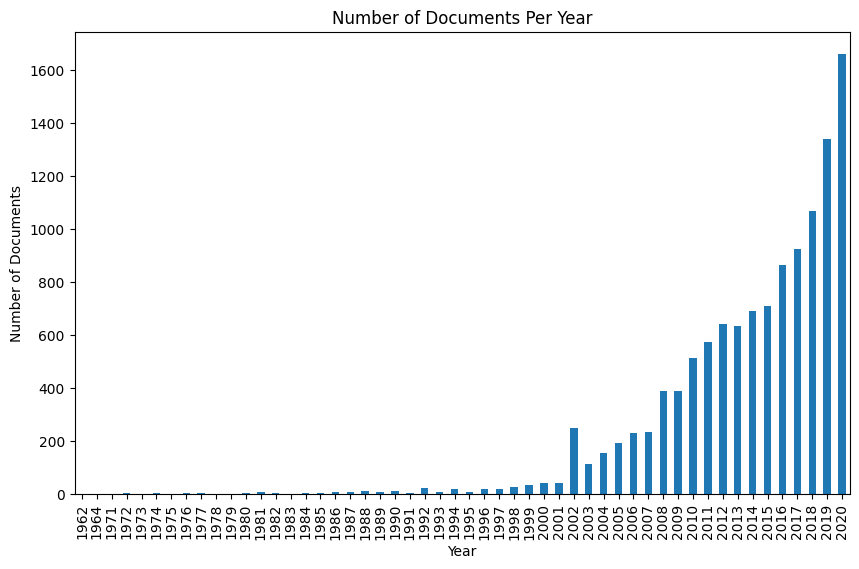

In [73]:
import matplotlib.pyplot as plt

df['year'] = df['date'].dt.year
documents_per_year = df.groupby('year').size()

plt.figure(figsize=(10,6))
documents_per_year.plot(kind='bar')
plt.title('Number of Documents Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Documents')
plt.show()

#### abstract

In [74]:
df['word_count_abstract'] = df['abstract'].apply(lambda x: len(str(x).split()))
average_word_count = round(df['word_count_abstract'].mean())
print(f"The abstracts of the documents in the dataset contain an average of {average_word_count} words.")
df.drop(columns=['word_count_abstract'], inplace=True)

The abstracts of the documents in the dataset contain an average of 194 words.


### Text Analysis

In [75]:
import nltk 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet') 


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [82]:
from string import punctuation

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = stopwords.words('english')

np = [
    ''.join([char for char in abs if char not in punctuation])
    for abs in df["abstract"]
]
print(np[:5])

token_abs = [word_tokenize(abs) for abs in np]
print(token_abs[:5])

abs_nstp = [
    ' '.join([word.lower() for word in abs if word.lower() not in stop_words])
    for abs in token_abs
]

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 
abs_lem = [
    ' '.join([lemmatizer.lemmatize(word) for word in abs.split()])
    for abs in abs_nstp
]


df['lem_abstract'] = abs_lem

from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

abs_stem = [
    ' '.join([stemmer.stem(word) for word in abs.split()])
    for abs in abs_nstp
]

df['stem_abstract'] = abs_stem
df.to_csv("covid_dataset_preprocessed.csv", index=False)



['OBJECTIVE This retrospective chart review describes the epidemiology and clinical features of 40 patients with cultureproven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital Jeddah Saudi Arabia METHODS Patients with positive M pneumoniae cultures from respiratory specimens from January 1997 through December 1998 were identified through the Microbiology records Charts of patients were reviewed RESULTS 40 patients were identified 33 825 of whom required admission Most infections 925 were communityacquired The infection affected all age groups but was most common in infants 325 and preschool children 225 It occurred yearround but was most common in the fall 35 and spring 30 More than threequarters of patients 775 had comorbidities Twentyfour isolates 60 were associated with pneumonia 14 35 with upper respiratory tract infections and 2 5 with bronchiolitis Cough 825 fever 75 and malaise 588 were the most common symptoms and crepitations 60 and wheezes 40 were the mo

### Most Common Words

In [81]:
from collections import Counter

lem_tokenized = [word_tokenize(abs) for abs in df['lem_abstract']]

word_freq = Counter()
for abs in lem_tokenized:
    word_freq.update(abs)

most_common_words = word_freq.most_common(20)

for word, freq in most_common_words:
    print(f"{word}: {freq}")

virus: 10419
patient: 10341
infection: 9049
cell: 8790
disease: 8199
study: 7735
result: 5446
protein: 5329
human: 4505
influenza: 4389
viral: 4334
method: 4062
also: 3791
may: 3773
health: 3764
response: 3743
model: 3634
clinical: 3609
respiratory: 3556
data: 3519


#### Word Cloud

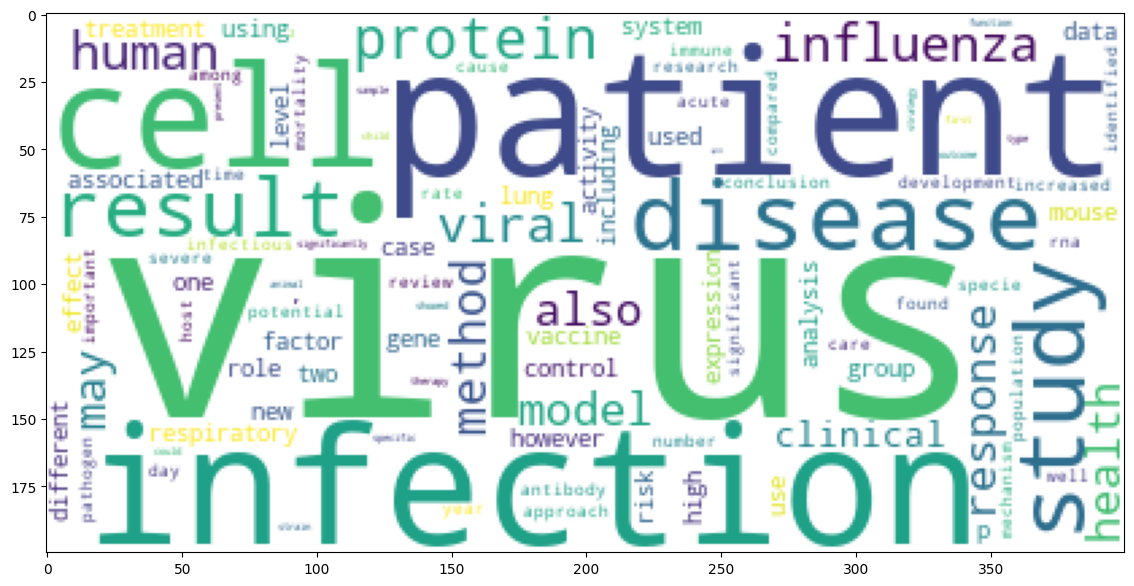

In [80]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt

wc = WordCloud(
    background_color='white',
    max_words=100,
    random_state=44,
    max_font_size=110
)
wc.generate_from_frequencies(word_freq)
plt.figure(figsize=(50, 7))
plt.imshow(wc)
plt.show()





## Prospective Search Task

### Description

The aim of this project is to build an information retrieval system that can effectively search and retrieve relevant scientific articles on COVID. The system should handle multiple query types across various topics and provide comprehensive results. Below are the key search tasks:

### Search Tasks

1. **Find articles about specific COVID variants by their name (e.g., Delta, Omicron) or genomic mutations.**

2. **Search information about COVID spread (e.g. its transmission routes).**

3. **Search for COVID symptoms, diagnostic criteria, and clinical presentation.**  

4. **Search therapeutic strategies, clinical management of COVID cases, and recovery protocols** 

5. **Search developed vaccines, their efficacy, distribution, and the use of therapeutic drugs.**

